## Factor selection problem

In [3]:
import pandas as pd

#Load Returns
eq_wt_df_all= pd.read_csv("./data/Returns_Equal_Weighted.csv")
print(eq_wt_df_all.head(3))

       date    absacc       acc       age       agr        bm     bm_ia  \
0  19800131  0.020437 -0.019961  0.004841 -0.051247  0.002593  0.026180   
1  19800229  0.015636 -0.000363 -0.018122 -0.014145 -0.021253 -0.004250   
2  19800331 -0.040065 -0.018086 -0.014526  0.001264  0.033694  0.022895   

       cash  cashdebt    cashpr     ...            ms        ps     nincr  \
0  0.005222 -0.066361  0.038807     ...     -0.062844 -0.021583  0.003167   
1  0.003154 -0.027831  0.025499     ...     -0.026242 -0.023228 -0.017170   
2 -0.003068  0.042815 -0.055649     ...      0.042198  0.025033  0.008833   

       divi      divo        rd       sin       IPO   convind  securedind  
0 -0.031233 -0.031233 -0.031233  0.096761  0.096761  0.004620    0.096761  
1 -0.051512 -0.051512 -0.051512 -0.014712 -0.014712 -0.003763   -0.014712  
2  0.011847  0.011847  0.011847 -0.160399 -0.160399 -0.008245   -0.160399  

[3 rows x 103 columns]


These returns are the single factor portfolio monthly returns from 1980 to 2014. The single factor portfolio is formed by long top decile and short last decile of predicted return of stocks. The stocks in the portfolio are either equal weighted or value weighted.
The prediction of stock return is done using by cross-sectional regression of the individual factors for a rolling 120 month period.
Our aim is to narrow down to few factors qualitatively and quantitatively.

The factors and their monthly returns are referenced from : "The Characteristics that Provide Independent Information about Average U.S. Monthly Stock Returns" : Green, Hand, Zhang [2016]

As their findings state, among the 102 factors, there are 8 factors having VIF > 7 and we first remove those factors to bring down the multicollinearity.

In [4]:
#Drop columns betasq, dolvol, maxret, mom6m, pchquick, quick, stdacc and lgr

drop_list = ['date','betasq', 'dolvol', 'maxret', 'mom6m', 'pchquick', 'quick', 'stdacc','lgr']
eq_wt_df = eq_wt_df_all.drop(drop_list, axis=1)


Next, we select the factors which are statistically signficant in Fama-MacBeth (FM) regressions of monthly stock returns on each of the 94 firm characteristics studied one at a time(No benchmark model control). 
We narrow down to factors having t-stat >= 3


In [5]:
select_list = ['agr','bm','aeavol','cashpr','chatoia','chcsho','chempia','chfeps','chinv','chmom','chtx','convind','ear','egr',
              'grcapx','grltnoa','hire','ill','indmom','invest','mom1m','nincr','orgcap','pchgm_pchsale','pchsale_pchinvt',
              'pchsale_pchrect','pchsale_pchxsga','pctacc','rd_mve','sgr','sp','sue','turn']

eq_wt_df = eq_wt_df[select_list]

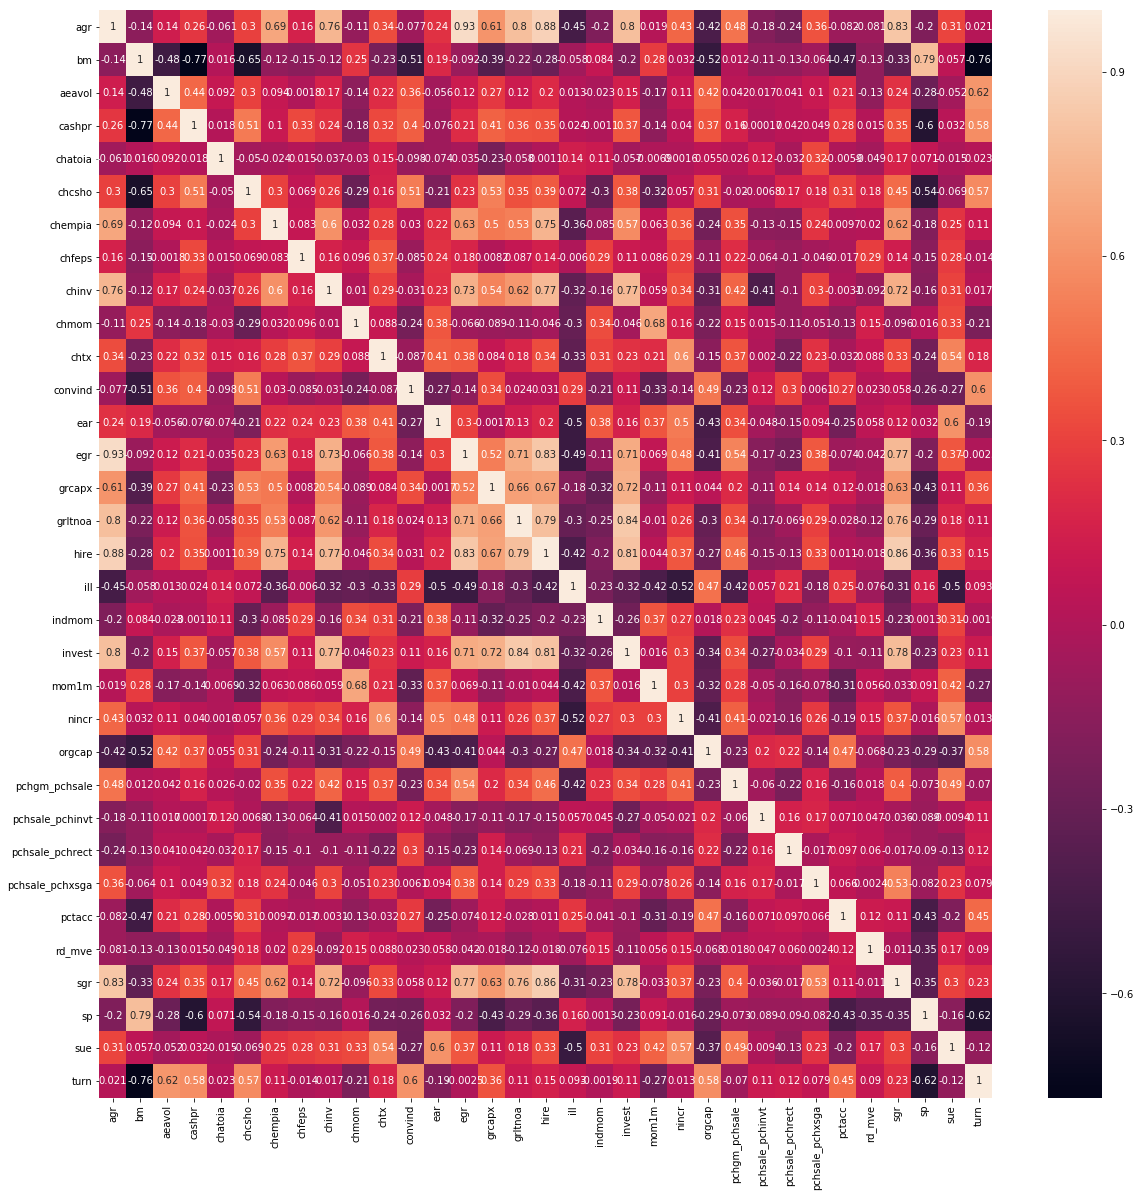

In [6]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

# calculate the correlation matrix
corr = eq_wt_df.corr()

# plot the heatmap
fig, ax = plt.subplots(figsize=(20,20))   
sns.heatmap(corr,annot=True, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

Cross correlation looks good with only small patches with high values in the range of 0.7s. We can live with it.


As per the analysis done in The Supraview of Return Predictive Signals:Green, Hand, Zhang [2012], we can calculate the average correlation among the factors as:
$$ \rho = 2*\sum^{s=S}_{s=1}\sum^{s=s+1}_{s=S} \frac{\rho_{s,t}}{S(S-1)}$$

where the double summation term is the sum of upper triagular correlation matrix without the diagonal elements. We calculate the same in the below cell.

In [7]:
#Get upper triangular matrix without diagonal elements
no_factors = len(corr)
corr_u = np.triu(corr) - np.eye(no_factors)

#Print the average pairwise correlation
rho_bar = (np.sum(corr_u)*2)/(no_factors*(no_factors-1))
print(rho_bar)

0.08483797099961397


The average correlation is pretty low and we can proceed with the selected factors.

In [8]:
#Annualized returns of the factors
cum_fact_rets = np.cumprod(eq_wt_df+np.ones(eq_wt_df.shape))

cum_facts_annualized = np.power(cum_fact_rets.iloc[-1:,:],12/len(cum_fact_rets))-1

#Annualized Std deviation of the factors
std_d = np.std(eq_wt_df,axis=0)*np.sqrt(12)
SR_facts = np.round(cum_facts_annualized/std_d,2)

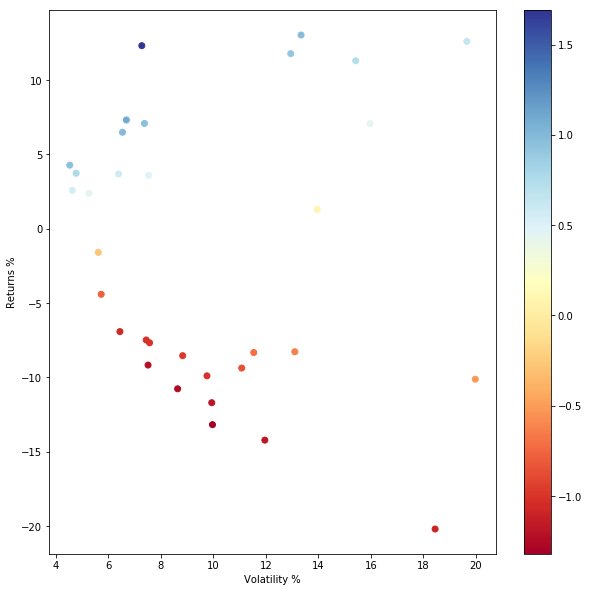

In [37]:

fig, ax = plt.subplots(figsize=(10,10))  
plt.scatter(np.array(np.round(std_d*100,4)),np.array(np.round(cum_facts_annualized*100,4)),c=np.array(SR_facts),cmap='RdYlBu')
plt.ylabel("Returns %")
plt.xlabel("Volatility %")
plt.colorbar()

Lets select the blue colored factors and individually analyse them:

In [12]:
Factors_selected= SR_facts[SR_facts>=0.5]
Factors_selected = Factors_selected.dropna(axis=1)
#df1.drop(droplist,axis=1,inplace=True)
print(Factors_selected)

       bm  chatoia  chfeps  chtx  ear  indmom  nincr  pchgm_pchsale  \
419  0.98     0.78    0.91  0.96  1.1    0.64   0.99           0.58   

     pchsale_pchinvt  pchsale_pchrect    sp   sue  
419             0.95             0.56  0.73  1.69  


The return statistics of the above filtered factors are not great. However, lets still understand the factors since the period of testing is 34 years which is quite respectable.


Factor	Description
-   bm :	Book value of equity (ceq) divided by end of fiscal-year-end market capitalization.
-   chatoia :	2-digit SIC - fiscal-year mean adjusted change in sales (sale) divided by average total assets (at).
-   chfeps : 	Mean analyst forecast in month prior to fiscal period end date from I/B/E/S summary file minus same mean forecast for prior fiscal period using annual earnings forecasts.
-   chtx	: Percent change in total taxes (txtq) from quarter t-4 to t.
-   ear :	Sum of daily returns in three days around earnings announcement. Earnings announcement from 
-   indmom :	Equal weighted average industry 12-month returns.
-   nincr :	Number of consecutive quarters (up to eight quarters) with an increase in earnings (ibq) over same quarter in the prior year.
-   pchgm_pchsale :	Percent change in gross margin (sale-cogs) minus percent change in sales (sale).
-   pchsaleinv :	Percent change in saleinv
-   pchsale_pchrect :	Annual percent change in sales (sale) minus annual percent change in receivables (rect).
-   sp :	Annual revenue (sale) divided by fiscal-year-end market capitalization.
-   sue :	Unexpected quarterly earnings divided by fiscal-quarter-end market cap.  Unexpected earnings is I/B/E/S actual earnings 
-   minus : median forecasted earnings if available, else it is the seasonally differenced quarterly earnings before extraordinary items 


Almost all except(BM) can be attributed to 'Quality' factors. So in addition to the above quality factors we would also add some 'Value','Momentum' based factors to the list.

Lets identify some momentum and value/growth factors and check their returns.
Momentum_facts = ['chmom','maxret','mom12m','mom1m','mom36m','mom6m']
VG_Factors = ['bm','fgr5yr','grltnoa','rd']

selected momentum factor:
     mom12m  mom6m
419  0.2494  0.139
selected V/G factor:
       bm    rd
419  0.98  0.58


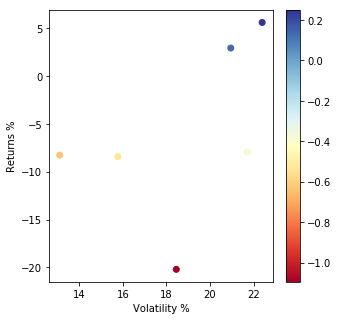

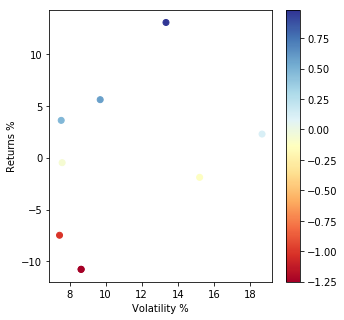

In [39]:

Momentum_facts = ['chmom','maxret','mom12m','mom1m','mom36m','mom6m']
VG_Factors = ['bm','fgr5yr','grltnoa','sfe','rd','rd_mve','rd_sale','grltnoa','grcapx']

mom_facts = eq_wt_df_all[Momentum_facts]
vg_facts = eq_wt_df_all[VG_Factors]

#Annualized returns of the Momentum factors
cum_momfact_rets = np.cumprod(mom_facts+np.ones(mom_facts.shape))

cum_momfact_annual_rets = np.power(cum_momfact_rets.iloc[-1:,:],12/len(cum_momfact_rets))-1

#Annualized Std deviation of the Momentum factors
std_d_mom = np.std(mom_facts,axis=0)*np.sqrt(12)

SR_mom_facts = np.round(cum_momfact_annual_rets/std_d_mom,4)


#Annualized returns of the value/growth factors
cum_vgfact_rets = np.cumprod(vg_facts+np.ones(vg_facts.shape))

cum_vgfact_annual_rets = np.power(cum_vgfact_rets.iloc[-1:,:],12/len(cum_vgfact_rets))-1

#Annualized Std deviation of the value/growth factors
std_d_vg = np.std(vg_facts,axis=0)*np.sqrt(12)
SR_vg_facts = np.round(cum_vgfact_annual_rets/std_d_vg,2)

fig, ax = plt.subplots(figsize=(5,5))  
plt.scatter(np.array(np.round(std_d_mom*100,4)),np.array(np.round(cum_momfact_annual_rets*100,4)),c=np.array(SR_mom_facts),cmap='RdYlBu')
plt.ylabel("Returns %")
plt.xlabel("Volatility %")
plt.colorbar()

fig, ax = plt.subplots(figsize=(5,5))  
plt.scatter(np.array(np.round(std_d_vg*100,4)),np.array(np.round(cum_vgfact_annual_rets*100,4)),c=np.array(SR_vg_facts),cmap='RdYlBu')
plt.ylabel("Returns %")
plt.xlabel("Volatility %")
plt.colorbar()

mom_factors_selected= SR_mom_facts[SR_mom_facts>0]
mom_factors_selected = mom_factors_selected.dropna(axis=1)
#df1.drop(droplist,axis=1,inplace=True)
print("selected momentum factor:")
print(mom_factors_selected)

vg_factors_selected= SR_vg_facts[SR_vg_facts>0.5]
vg_factors_selected = vg_factors_selected.dropna(axis=1)
#df1.drop(droplist,axis=1,inplace=True)
print("selected V/G factor:")
print(vg_factors_selected)


Lets give a brief description of selected momentum and value/growth factors:

-   mom12m : 11-month cumulative returns ending one month before month end.
-   mom6m :	5-month cumulative returns ending one month before month end.
-   bm (already covered) 
-   rd : An indicator variable equal to 1 if R&D expense as a percentage of total assets has an increase greater than 5%.

Next, lets also check if we have missed any good performing factor from all the 102 factor universe.


selected  factor:
     ear   sue
419  1.1  1.69
(1, 2)


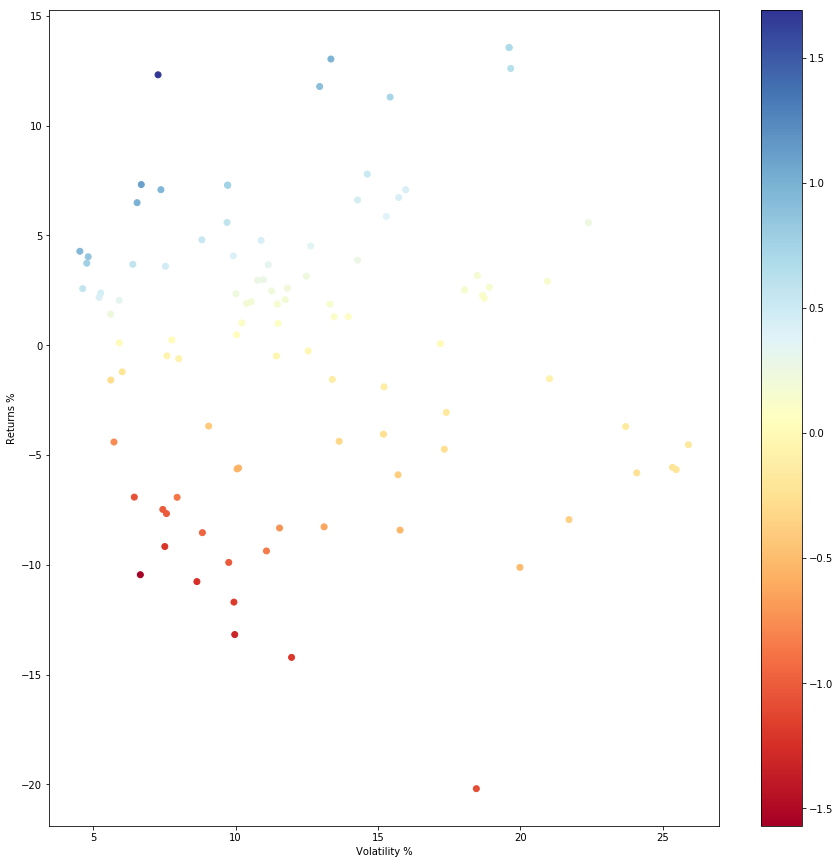

In [38]:
#Annualized returns of the factors
#eq_wt_df_all = eq_wt_df_all.drop(['date'],axis=1)
cum_allfact_rets = np.cumprod(eq_wt_df_all+np.ones(eq_wt_df_all.shape))

cum_allfacts_annualized = np.power(cum_allfact_rets.iloc[-1:,:],12/len(cum_allfact_rets))-1

#Annualized Std deviation of the factors
std_d_all = np.std(eq_wt_df_all,axis=0)*np.sqrt(12)
SR_facts_all = np.round(cum_allfacts_annualized/std_d_all,2)

fig, ax = plt.subplots(figsize=(15,15))  
plt.scatter(np.array(np.round(std_d_all*100,4)),np.array(np.round(cum_allfacts_annualized*100,4)),c=np.array(SR_facts_all),cmap='RdYlBu')
plt.ylabel("Returns %")
plt.xlabel("Volatility %")
plt.colorbar()


all_selected= SR_facts_all[SR_facts_all>=1]
all_selected = all_selected.dropna(axis=1)
#df1.drop(droplist,axis=1,inplace=True)
print("selected  factor:")
print(all_selected)
print(all_selected.shape)

'ear' and 'sue' have already been selected. So our final set of factors are:

-  Quality :  bm,  chatoia,  chfeps,  chtx, ear,  indmom,  nincr,  pchgm_pchsale, pchsale_pchinvt,  pchsale_pchrect,    sp,   sue
-  Value/Growth : bm, rd
-  Momentum : mom12m, mom6m

Next, we can allocate the factor portfolios QVM weight based on our market outlook. My ball-park figure for allocation would be 50% quality, 25% value and 25% momentum with the expectation of a downcycle next fiscal year. However,  we need to find better factors for value and momentum.